<a href="https://colab.research.google.com/github/metalimangal/Schelling-and-Hofstede/blob/main/Dynamic_NPC's_implementation_using_Hofstede's_theory_and_Schelling's_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic NPC's implementation using Hofstede's theory and Schelling's theory

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets


# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
grid_size = 20  # Size of the grid (20x20)
n_groups = 3    # Number of groups (Group 1, Group 2, Group 3)
empty_cell = 0  # Represents an empty cell
tolerance = [0.5, 0.5, 0.5]  # Tolerance threshold for each group
n_iterations = 100  # Maximum number of simulation iterations

# Initialize the grid
def initialize_grid():
    grid = np.random.choice(
        [i + 1 for i in range(n_groups)] + [empty_cell],
        size=(grid_size, grid_size),
        p=[0.3, 0.3, 0.3, 0.1]  # Each group occupies 30%, empty cells occupy 10%
    )
    return grid

# Get Moore neighbors of a cell at position (x, y)
def get_moore_neighbors(x, y, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:  # Skip the cell itself
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:  # Boundary check
                neighbors.append(grid[nx, ny])
    return neighbors

# Nash Equilibrium movement function with tolerance consideration
def move_agents_nash_equilibrium_with_tolerance(grid, tolerance):
    agent_desires = {}  # Dictionary to store each agent's desired move positions
    empty_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == empty_cell]

    # Iterate over all cells in the grid
    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == empty_cell:
                continue  # Skip empty cells
            agent_type = grid[x, y]

            # Calculate the agent's current utility (satisfaction) at its current position
            current_neighbors = get_moore_neighbors(x, y, grid)
            current_similar_count = current_neighbors.count(agent_type)
            if current_neighbors:
                current_similarity_ratio = current_similar_count / len(current_neighbors)
            else:
                current_similarity_ratio = 1  # If no neighbors, consider fully satisfied

            # Check if the agent is dissatisfied
            if current_similarity_ratio < tolerance[agent_type - 1]:
                max_utility = current_similarity_ratio  # Initialize max utility with current utility
                desired_move = None  # Initialize desired move as None

                # Evaluate all possible moves to empty cells
                for (i, j) in empty_cells:
                    # Simulate moving the agent to the empty cell
                    grid[i, j] = agent_type  # Place agent at new position
                    grid[x, y] = empty_cell  # Empty the original position temporarily

                    # Calculate potential utility at the new position
                    potential_neighbors = get_moore_neighbors(i, j, grid)
                    potential_similar_count = potential_neighbors.count(agent_type)
                    if potential_neighbors:
                        potential_similarity_ratio = potential_similar_count / len(potential_neighbors)
                    else:
                        potential_similarity_ratio = 1  # If no neighbors, consider fully satisfied

                    # Restore the grid to its original state
                    grid[x, y] = agent_type  # Move agent back to original position
                    grid[i, j] = empty_cell  # Empty the new position

                    # If the potential utility is higher than the current utility, update desired move
                    if potential_similarity_ratio > max_utility:
                        max_utility = potential_similarity_ratio
                        desired_move = (i, j)

                # If a better position is found, record the agent's desired move
                if desired_move:
                    agent_desires[(x, y)] = desired_move

    # Resolve conflicts where multiple agents desire the same destination
    destination_agents = {}
    for agent_pos, dest_pos in agent_desires.items():
        destination_agents.setdefault(dest_pos, []).append(agent_pos)

    # Randomize the order of destinations to avoid processing order bias
    destinations = list(destination_agents.keys())
    random.shuffle(destinations)

    for dest_pos in destinations:
        agent_positions = destination_agents[dest_pos]
        if len(agent_positions) == 1:
            # Only one agent desires this position; move the agent
            agent_pos = agent_positions[0]
        else:
            # Multiple agents desire the same position
            # Resolve conflict by randomly selecting one agent to move
            agent_pos = random.choice(agent_positions)
        # Execute the move
        x, y = agent_pos
        i, j = dest_pos
        agent_type = grid[x, y]
        grid[i, j] = agent_type  # Move agent to new position
        grid[x, y] = empty_cell  # Empty the original position
        # Update the list of empty cells
        empty_cells.remove((i, j))
        empty_cells.append((x, y))
        # Remove the moved agent from other agents' desire lists to prevent it from moving again
        for other_dest, agents in destination_agents.items():
            if agent_pos in agents and other_dest != dest_pos:
                agents.remove(agent_pos)


# Calculate segregation percentage: the percentage of dissatisfied individuals
def calculate_segregation_percentage(grid):
    total_similarity = 0
    total_individuals = 0

    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == empty_cell:
                continue
            neighbors = get_moore_neighbors(x, y, grid)
            if neighbors:
                similar_count = neighbors.count(grid[x, y])
                similarity_ratio = similar_count / len(neighbors)
                total_similarity += similarity_ratio
                total_individuals += 1

    return (total_similarity / total_individuals) * 100 if total_individuals > 0 else 0

# Store the grid at each iteration
def run_simulation():
    grid = initialize_grid()  # Start with a random grid
    grids_over_time = [grid.copy()]  # List to store the grid at each iteration
    segregation_percentages = []

    for iteration in range(n_iterations):
        move_agents_nash_equilibrium_with_tolerance(grid, tolerance)
        grids_over_time.append(grid.copy())  # Save the grid after each move
        segregation_percentages.append(calculate_segregation_percentage(grid))

    return grids_over_time,  segregation_percentages

# Run the simulation and get all the grids over time
grids_over_time, segregation_percentages = run_simulation()

# Function to update the grid display

def update_plot(iteration):
    # Clear the current figure
    plt.clf()

    # Create a subplot for the grid
    plt.subplot(1, 2, 1)
    grid = grids_over_time[iteration]
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.title(f"Iteration: {iteration}")
    plt.axis("off")  # Hide axes

    # Create a subplot for the segregation percentage graph
    plt.subplot(1, 2, 2)
    plt.plot(range(iteration), segregation_percentages[:iteration], label="Segregation %")
    plt.xlabel("Iterations")
    plt.ylabel("Segregation Percentage")
    plt.title("Segregation Over Iteration")
    plt.legend()
    plt.show()

# Create a slider to control the iteration
iteration_slider = widgets.IntSlider(value=0, min=0, max=n_iterations, step=1, description='Iteration:')
widgets.interactive(update_plot, iteration=iteration_slider)



interactive(children=(IntSlider(value=0, description='Iteration:'), Output()), _dom_classes=('widget-interact'…

Improving Nash equi:

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets


# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
grid_size = 20  # Size of the grid (20x20)
n_groups = 3    # Number of groups (Group 1, Group 2, Group 3)
empty_cell = 0  # Represents an empty cell
tolerance = [0.5, 0.5, 0.5]  # Tolerance threshold for each group
n_iterations = 100  # Maximum number of simulation iterations

# Initialize the grid
def initialize_grid():
    grid = np.random.choice(
        [i + 1 for i in range(n_groups)] + [empty_cell],
        size=(grid_size, grid_size),
        p=[0.3, 0.3, 0.3, 0.1]  # Each group occupies 30%, empty cells occupy 10%
    )
    return grid

# Get Moore neighbors of a cell at position (x, y)
def get_moore_neighbors(x, y, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:  # Skip the cell itself
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:  # Boundary check
                neighbors.append(grid[nx, ny])
    return neighbors

def move_agents_with_diversity_incentive(grid, tolerance):
    agent_desires = {}
    empty_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == empty_cell]

    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == empty_cell:
                continue
            agent_type = grid[x, y]

            # Calculate current utility
            current_neighbors = get_moore_neighbors(x, y, grid)
            current_similar_count = current_neighbors.count(agent_type)
            current_dissimilar_count = len(current_neighbors) - current_similar_count
            current_similarity_ratio = current_similar_count / len(current_neighbors) if current_neighbors else 1

            # Check dissatisfaction
            if current_similarity_ratio < tolerance[agent_type - 1]:
                max_utility = current_similarity_ratio - 0.1 * current_dissimilar_count
                desired_move = None

                for (i, j) in empty_cells:
                    # Simulate the move
                    grid[i, j] = agent_type
                    grid[x, y] = empty_cell

                    # Calculate potential utility
                    potential_neighbors = get_moore_neighbors(i, j, grid)
                    potential_similar_count = potential_neighbors.count(agent_type)
                    potential_dissimilar_count = len(potential_neighbors) - potential_similar_count
                    potential_similarity_ratio = (
                        potential_similar_count / len(potential_neighbors) if potential_neighbors else 1
                    )

                    # Add diversity incentive
                    potential_utility = potential_similarity_ratio - 0.1 * potential_dissimilar_count

                    # Restore grid state
                    grid[x, y] = agent_type
                    grid[i, j] = empty_cell

                    if potential_utility > max_utility:
                        max_utility = potential_utility
                        desired_move = (i, j)

                if desired_move:
                    agent_desires[(x, y)] = desired_move

    # Resolve conflicts
    destination_agents = {}
    for agent_pos, dest_pos in agent_desires.items():
        destination_agents.setdefault(dest_pos, []).append(agent_pos)

    destinations = list(destination_agents.keys())
    random.shuffle(destinations)

    for dest_pos in destinations:
        agent_positions = destination_agents[dest_pos]
        if len(agent_positions) == 1:
            agent_pos = agent_positions[0]
        else:
            agent_pos = random.choice(agent_positions)
        x, y = agent_pos
        i, j = dest_pos
        agent_type = grid[x, y]
        grid[i, j] = agent_type
        grid[x, y] = empty_cell
        empty_cells.remove((i, j))
        empty_cells.append((x, y))

# Calculate segregation percentage: the percentage of dissatisfied individuals
def calculate_segregation_percentage(grid):
    total_similarity = 0
    total_individuals = 0

    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == empty_cell:
                continue
            neighbors = get_moore_neighbors(x, y, grid)
            if neighbors:
                similar_count = neighbors.count(grid[x, y])
                similarity_ratio = similar_count / len(neighbors)
                total_similarity += similarity_ratio
                total_individuals += 1

    return (total_similarity / total_individuals) * 100 if total_individuals > 0 else 0


# Update the run_simulation function to use the new movement logic
def run_simulation():
    grid = initialize_grid()
    grids_over_time = [grid.copy()]
    segregation_percentages = []

    for iteration in range(n_iterations):
        move_agents_with_diversity_incentive(grid, tolerance)
        grids_over_time.append(grid.copy())
        segregation_percentages.append(calculate_segregation_percentage(grid))

    return grids_over_time, segregation_percentages


# Visualizing the segregation percentage graph
grids_over_time, segregation_percentages = run_simulation()


# Function to update the grid display

def update_plot(iteration):
    # Clear the current figure
    plt.clf()

    # Create a subplot for the grid
    plt.subplot(1, 2, 1)
    grid = grids_over_time[iteration]
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.title(f"Iteration: {iteration}")
    plt.axis("off")  # Hide axes

    # Create a subplot for the segregation percentage graph
    plt.subplot(1, 2, 2)
    plt.plot(range(iteration), segregation_percentages[:iteration], label="Segregation %")
    plt.xlabel("Iterations")
    plt.ylabel("Segregation Percentage")
    plt.title("Segregation Over Iteration")
    plt.legend()
    plt.show()

# Create a slider to control the iteration
iteration_slider = widgets.IntSlider(value=0, min=0, max=n_iterations, step=1, description='Iteration:')
widgets.interactive(update_plot, iteration=iteration_slider)



interactive(children=(IntSlider(value=0, description='Iteration:'), Output()), _dom_classes=('widget-interact'…

Simulated Annealing

interactive(children=(IntSlider(value=0, description='Iteration:'), Output()), _dom_classes=('widget-interact'…

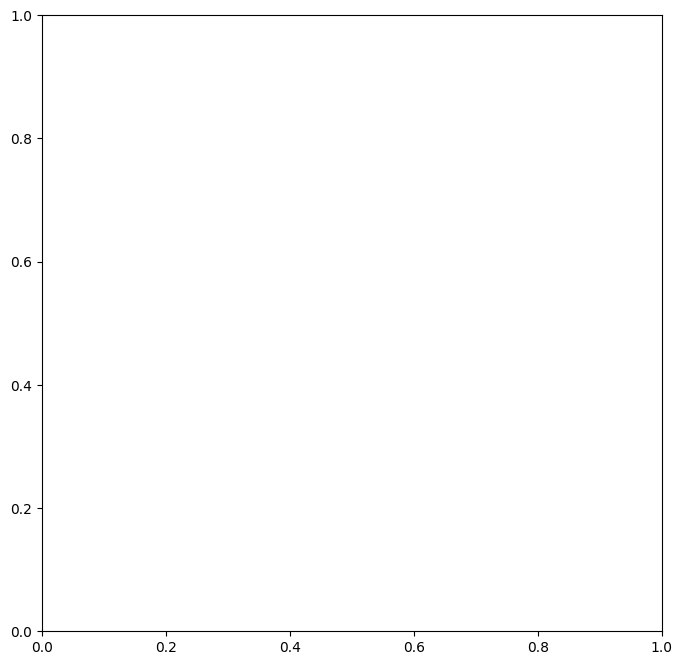

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
grid_size = 20  # Size of the grid (20x20)
n_groups = 3  # Number of groups (Group 1, Group 2, Group 3)
empty_cell = 0  # Empty cell (no one lives here)
tolerance = [0.5, 0.5, 0.5]  # Tolerance thresholds for each group (Group 1, Group 2, Group 3)
n_iterations = 100  # Number of iterations for the simulation

initial_temperature = 10.0  # Starting temperature for SA
cooling_rate = 0.95  # Cooling rate for SA

# Initialize the grid
def initialize_grid():
    grid = np.random.choice([i+1 for i in range(n_groups)] + [empty_cell],
                            size=(grid_size, grid_size),
                            p=[0.3, 0.3, 0.3, 0.1])  # 30% for each group, 10% empty
    return grid

# Get neighbors for Moore neighborhood
def get_moore_neighbors(x, y, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbors.append(grid[nx, ny])
    return neighbors

# Check satisfaction and calculate penalty
def tolerance_penalty(x, y, grid, tolerance):
    neighbors = get_moore_neighbors(x, y, grid)
    if len(neighbors) == 0:
        return 0  # No neighbors, no penalty
    similar_count = neighbors.count(grid[x, y])
    similarity_ratio = similar_count / len(neighbors)
    # Calculate penalty based on difference from tolerance
    penalty = max(0, tolerance - similarity_ratio)
    return penalty

# Calculate overall dissatisfaction with tolerance penalties
def calculate_dissatisfaction(grid):
    dissatisfaction = 0
    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] != empty_cell:
                dissatisfaction += tolerance_penalty(x, y, grid, tolerance[grid[x, y] - 1])
    return dissatisfaction

# Simulated Annealing step
def simulated_annealing_step(grid, temperature):
    dissatisfied = [
        (x, y)
        for x in range(grid_size)
        for y in range(grid_size)
        if grid[x, y] != empty_cell and
        tolerance_penalty(x, y, grid, tolerance[grid[x, y] - 1]) > 0
    ]
    current_dissatisfaction = calculate_dissatisfaction(grid)
    empty_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == empty_cell]

    # Move dissatisfied individuals to random empty spots
    random.shuffle(dissatisfied)  # Shuffle the list to move individuals randomly

    # if dissatisfied and empty_cells:
    for (x, y) in dissatisfied:
        if not empty_cells: continue
        i, j = empty_cells.pop()

        # Swap and evaluate new dissatisfaction
        grid[i, j], grid[x, y] = grid[x, y], grid[i, j]
        new_dissatisfaction = calculate_dissatisfaction(grid)

        # Accept or revert based on probability
        if new_dissatisfaction > current_dissatisfaction:
            acceptance_probability = np.exp((current_dissatisfaction - new_dissatisfaction) / temperature)
            if random.random() > acceptance_probability:
                # Revert the move
                grid[x, y], grid[i, j] = grid[i, j], grid[x, y]

# Run the simulation with Simulated Annealing
def run_simulation():
    grid = initialize_grid()
    grids_over_time = [grid.copy()]
    temperature = initial_temperature

    for iteration in range(n_iterations):
        simulated_annealing_step(grid, temperature)
        grids_over_time.append(grid.copy())
        temperature *= cooling_rate  # Decrease temperature

    return grids_over_time

# Run the simulation and get all grids over time
grids_over_time = run_simulation()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Function to update the grid display
def update_plot(iteration):
    # Clear the current figure
    plt.clf()

    # Create a subplot for the grid
    plt.subplot(1, 2, 1)
    grid = grids_over_time[iteration]
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.title(f"Iteration: {iteration}")
    plt.axis("off")  # Hide axes


    # Create a subplot for the segregation percentage graph
    plt.subplot(1, 2, 2)
    plt.plot(range(iteration), segregation_percentages[:iteration], label="Segregation %")
    plt.xlabel("Iterations")
    plt.ylabel("Segregation Percentage")
    plt.title("Segregation Over Iteration")
    plt.legend()
    plt.show()

# Create a slider to control the iteration
iteration_slider = widgets.IntSlider(value=0, min=0, max=n_iterations, step=1, description='Iteration:')
widgets.interactive(update_plot, iteration=iteration_slider)

# Better Simulated Annealing:

interactive(children=(IntSlider(value=0, description='Iteration:'), Output()), _dom_classes=('widget-interact'…

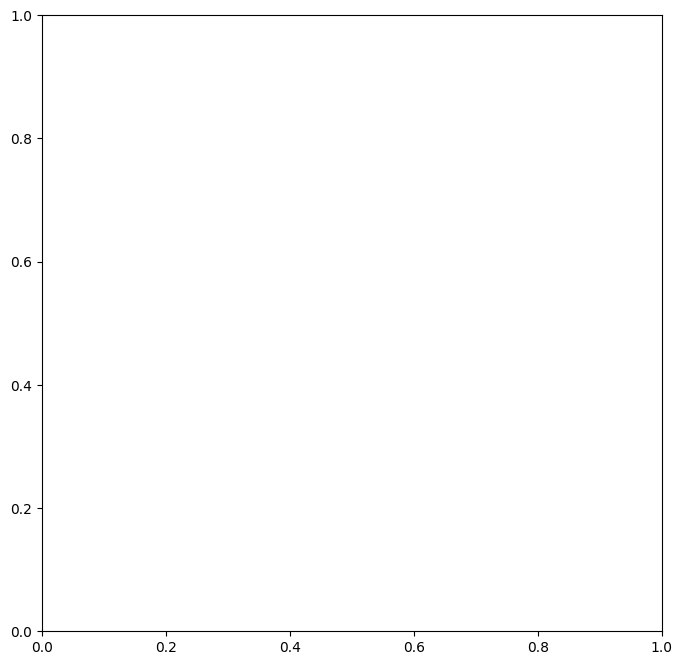

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
grid_size = 20  # Size of the grid (20x20)
n_groups = 3  # Number of groups (Group 1, Group 2, Group 3)
empty_cell = 0  # Empty cell (no one lives here)
tolerance = [0.5, 0.5, 0.5]  # Tolerance thresholds for each group (Group 1, Group 2, Group 3)
n_iterations = 100  # Number of iterations for the simulation

initial_temperature = 10.0  # Starting temperature for SA
cooling_rate = 0.95  # Cooling rate for SA

# Initialize the grid
def initialize_grid():
    grid = np.random.choice([i+1 for i in range(n_groups)] + [empty_cell],
                            size=(grid_size, grid_size),
                            p=[0.3, 0.3, 0.3, 0.1])  # 30% for each group, 10% empty
    return grid

# Get neighbors for Moore neighborhood
def get_moore_neighbors(x, y, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbors.append(grid[nx, ny])
    return neighbors

# Check satisfaction and calculate penalty
def tolerance_penalty(x, y, grid, tolerance):
    neighbors = get_moore_neighbors(x, y, grid)
    if len(neighbors) == 0:
        return 0  # No neighbors, no penalty
    similar_count = neighbors.count(grid[x, y])
    similarity_ratio = similar_count / len(neighbors)
    penalty = max(0, tolerance - similarity_ratio)
    return penalty

# Calculate overall dissatisfaction with tolerance penalties
def calculate_dissatisfaction(grid):
    dissatisfaction = 0
    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] != empty_cell:
                dissatisfaction += tolerance_penalty(x, y, grid, tolerance[grid[x, y] - 1])
    return dissatisfaction

# Simulated Annealing step with improved movement strategy
def simulated_annealing_step(grid, temperature):
    dissatisfied = [
        (x, y)
        for x in range(grid_size)
        for y in range(grid_size)
        if grid[x, y] != empty_cell and
        tolerance_penalty(x, y, grid, tolerance[grid[x, y] - 1]) > 0
    ]
    current_dissatisfaction = calculate_dissatisfaction(grid)
    empty_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == empty_cell]

    # Move dissatisfied individuals to random empty spots with improved strategy
    random.shuffle(dissatisfied)  # Shuffle the list to move individuals randomly

    for (x, y) in dissatisfied:
        if not empty_cells: continue
        i, j = empty_cells.pop()

        # Swap and evaluate new dissatisfaction
        grid[i, j], grid[x, y] = grid[x, y], grid[i, j]
        new_dissatisfaction = calculate_dissatisfaction(grid)

        # Accept or revert based on probability
        if new_dissatisfaction > current_dissatisfaction:
            acceptance_probability = np.exp((current_dissatisfaction - new_dissatisfaction) / temperature)
            if random.random() > acceptance_probability:
                # Revert the move
                grid[x, y], grid[i, j] = grid[i, j], grid[x, y]

    # Gradual reduction of tolerance to encourage mixing over time
    for i in range(n_groups):
        tolerance[i] = max(0.1, tolerance[i] - 0.01)  # Gradual decrease in tolerance to 0.1

# Run the simulation with Simulated Annealing
def run_simulation():
    grid = initialize_grid()
    grids_over_time = [grid.copy()]
    temperature = initial_temperature

    for iteration in range(n_iterations):
        simulated_annealing_step(grid, temperature)
        grids_over_time.append(grid.copy())
        temperature *= cooling_rate  # Decrease temperature

    return grids_over_time

# Run the simulation and get all grids over time
grids_over_time = run_simulation()

# Calculate segregation percentage: the percentage of dissatisfied individuals
def calculate_segregation_percentage(grid):
    total_similarity = 0
    total_individuals = 0

    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == empty_cell:
                continue
            neighbors = get_moore_neighbors(x, y, grid)
            if neighbors:
                similar_count = neighbors.count(grid[x, y])
                similarity_ratio = similar_count / len(neighbors)
                total_similarity += similarity_ratio
                total_individuals += 1

    return (total_similarity / total_individuals) * 100 if total_individuals > 0 else 0

# Store the grid at each iteration and segregation percentages
def run_simulation_and_plot():
    grid = initialize_grid()
    grids_over_time = [grid.copy()]
    segregation_percentages = [calculate_segregation_percentage(grid)]

    for iteration in range(n_iterations):
        simulated_annealing_step(grid, initial_temperature)
        grids_over_time.append(grid.copy())
        segregation_percentages.append(calculate_segregation_percentage(grid))

    return grids_over_time, segregation_percentages

grids_over_time, segregation_percentages = run_simulation_and_plot()

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(8, 8))

# Function to update the grid display
def update_plot(iteration):
    plt.clf()

    # Create a subplot for the grid
    plt.subplot(1, 2, 1)
    grid = grids_over_time[iteration]
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.title(f"Iteration: {iteration}")
    plt.axis("off")

    # Create a subplot for the segregation percentage graph
    plt.subplot(1, 2, 2)
    plt.plot(range(iteration + 1), segregation_percentages[:iteration + 1], label="Segregation %")
    plt.xlabel("Iterations")
    plt.ylabel("Segregation Percentage")
    plt.title("Segregation Over Iterations")
    plt.legend()
    plt.show()

# Create a slider to control the iteration
iteration_slider = widgets.IntSlider(value=0, min=0, max=n_iterations, step=1, description='Iteration:')
widgets.interactive(update_plot, iteration=iteration_slider)


Hofstede's and Nash

Adjusted Tolerance for Each Group: [0.48, 0.48, 0.495]


interactive(children=(IntSlider(value=0, description='Iteration:'), Output()), _dom_classes=('widget-interact'…

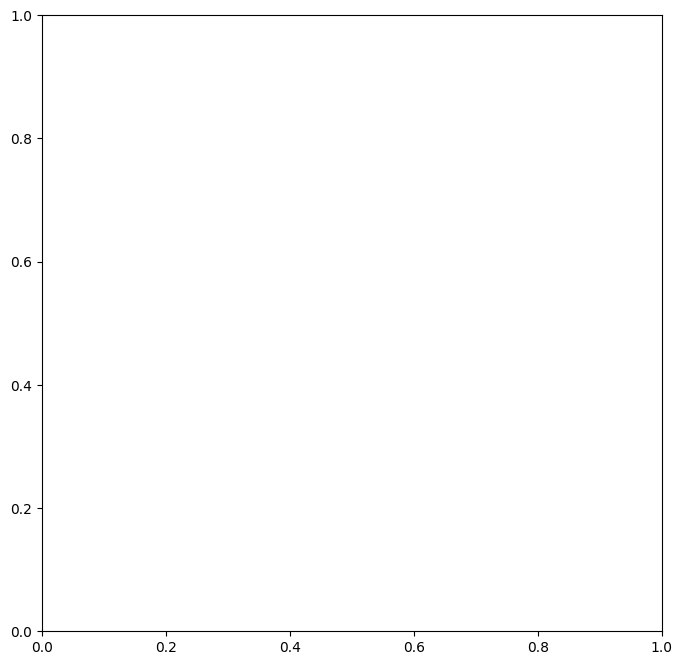

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
grid_size = 20  # Size of the grid (20x20)
n_groups = 3    # Number of groups (Group 1, Group 2, Group 3)
empty_cell = 0  # Represents an empty cell
n_iterations = 100  # Maximum number of simulation iterations

# Hofstede Dimensions for each group
hofstede_dimensions = {
    "Group 1": {"IDV": 0.4, "PDI": 0.5, "MAS": 0.5, "UAI": 0.5},
    "Group 2": {"IDV": 0.35, "PDI": 0.5, "MAS": 0.45, "UAI": 0.5},
    "Group 3": {"IDV": 0.45, "PDI": 0.45, "MAS": 0.55, "UAI": 0.45}
}

# Adjust tolerance based on Hofstede dimensions
def adjust_tolerance_based_on_hofstede():
    adjusted_tolerance = []
    for group in range(n_groups):
        group_name = f"Group {group + 1}"
        dimensions = hofstede_dimensions[group_name]
        tolerance_value = 0.5
        tolerance_value += (dimensions["IDV"] - 0.5) * 0.2
        tolerance_value -= (dimensions["PDI"] - 0.5) * 0.2
        tolerance_value -= (dimensions["MAS"] - 0.5) * 0.2
        tolerance_value -= (dimensions["UAI"] - 0.5) * 0.1
        tolerance_value = max(0.45, min(0.55, tolerance_value))
        adjusted_tolerance.append(tolerance_value)
    return adjusted_tolerance

tolerance = adjust_tolerance_based_on_hofstede()
print("Adjusted Tolerance for Each Group:", tolerance)

# Initialize the grid
def initialize_grid():
    grid = np.random.choice(
        [i + 1 for i in range(n_groups)] + [empty_cell],
        size=(grid_size, grid_size),
        p=[0.3, 0.3, 0.3, 0.1]
    )
    return grid

# Get Moore neighbors
def get_moore_neighbors(x, y, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbors.append(grid[nx, ny])
    return neighbors

# Nash Equilibrium movement function
def move_agents_nash_equilibrium_with_tolerance(grid, tolerance):
    agent_desires = {}
    empty_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == empty_cell]

    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == empty_cell:
                continue
            agent_type = grid[x, y]
            current_neighbors = get_moore_neighbors(x, y, grid)
            current_similar_count = current_neighbors.count(agent_type)
            current_similarity_ratio = current_similar_count / len(current_neighbors) if current_neighbors else 1

            if current_similarity_ratio < tolerance[agent_type - 1]:
                max_utility = current_similarity_ratio
                desired_move = None
                for (i, j) in empty_cells:
                    grid[i, j] = agent_type
                    grid[x, y] = empty_cell
                    potential_neighbors = get_moore_neighbors(i, j, grid)
                    potential_similarity_ratio = potential_neighbors.count(agent_type) / len(potential_neighbors) if potential_neighbors else 1
                    grid[x, y] = agent_type
                    grid[i, j] = empty_cell

                    if potential_similarity_ratio > max_utility:
                        max_utility = potential_similarity_ratio
                        desired_move = (i, j)

                if desired_move:
                    agent_desires[(x, y)] = desired_move

    destination_agents = {}
    for agent_pos, dest_pos in agent_desires.items():
        destination_agents.setdefault(dest_pos, []).append(agent_pos)

    for dest_pos, agent_positions in destination_agents.items():
        agent_pos = random.choice(agent_positions)
        x, y = agent_pos
        i, j = dest_pos
        grid[i, j] = grid[x, y]
        grid[x, y] = empty_cell

# Run simulation
def run_simulation():
    grid = initialize_grid()
    grids_over_time = [grid.copy()]
    for _ in range(n_iterations):
        move_agents_nash_equilibrium_with_tolerance(grid, tolerance)
        grids_over_time.append(grid.copy())
    return grids_over_time

# Visualization
grids_over_time = run_simulation()
fig, ax = plt.subplots(figsize=(8, 8))

def update_plot(iteration):
    # Clear the current figure
    plt.clf()

    # Create a subplot for the grid
    plt.subplot(1, 2, 1)
    grid = grids_over_time[iteration]
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.title(f"Iteration: {iteration}")
    plt.axis("off")  # Hide axes


    # Create a subplot for the segregation percentage graph
    plt.subplot(1, 2, 2)
    plt.plot(range(iteration), segregation_percentages[:iteration], label="Segregation %")
    plt.xlabel("Iterations")
    plt.ylabel("Segregation Percentage")
    plt.title("Segregation Over Iteration")
    plt.legend()
    plt.show()

# Create a slider to control the iteration
iteration_slider = widgets.IntSlider(value=0, min=0, max=n_iterations, step=1, description='Iteration:')
widgets.interactive(update_plot, iteration=iteration_slider)

Hofstede's with Simuleated Annealing

Adjusted Tolerance for Each Group: [0.48, 0.48, 0.495]


interactive(children=(IntSlider(value=0, description='Iteration:'), Output()), _dom_classes=('widget-interact'…

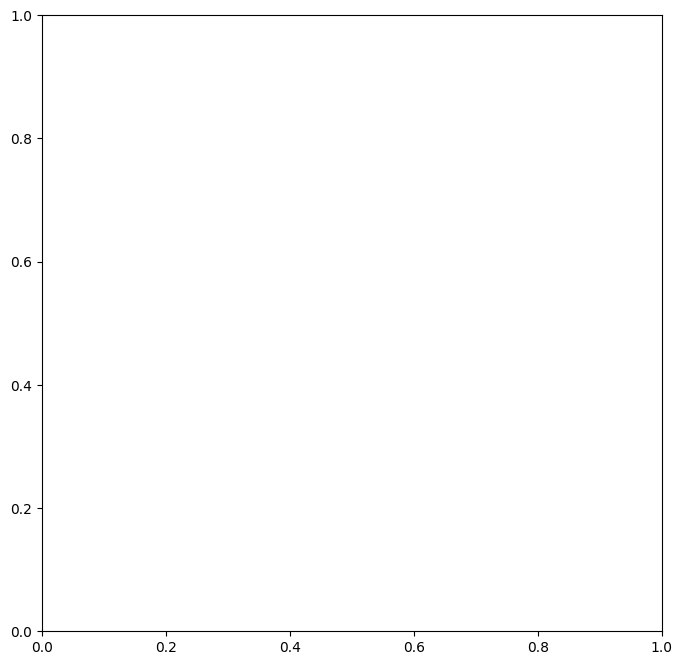

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
grid_size = 20
n_groups = 3
empty_cell = 0
n_iterations = 100
initial_temperature = 10.0
cooling_rate = 0.95

# Hofstede Dimensions for each group
hofstede_dimensions = {
    "Group 1": {"IDV": 0.4, "PDI": 0.5, "MAS": 0.5, "UAI": 0.5},
    "Group 2": {"IDV": 0.35, "PDI": 0.5, "MAS": 0.45, "UAI": 0.5},
    "Group 3": {"IDV": 0.45, "PDI": 0.45, "MAS": 0.55, "UAI": 0.45},
}

# Adjust tolerance based on Hofstede dimensions
def adjust_tolerance_based_on_hofstede():
    adjusted_tolerance = []
    for group in range(n_groups):
        group_name = f"Group {group + 1}"
        dimensions = hofstede_dimensions[group_name]
        tolerance_value = 0.5
        tolerance_value += (dimensions["IDV"] - 0.5) * 0.2
        tolerance_value -= (dimensions["PDI"] - 0.5) * 0.2
        tolerance_value -= (dimensions["MAS"] - 0.5) * 0.2
        tolerance_value -= (dimensions["UAI"] - 0.5) * 0.1
        tolerance_value = max(0.45, min(0.55, tolerance_value))
        adjusted_tolerance.append(tolerance_value)
    return adjusted_tolerance

tolerance = adjust_tolerance_based_on_hofstede()
print("Adjusted Tolerance for Each Group:", tolerance)

# Initialize the grid
def initialize_grid():
    grid = np.random.choice(
        [i + 1 for i in range(n_groups)] + [empty_cell],
        size=(grid_size, grid_size),
        p=[0.3, 0.3, 0.3, 0.1],
    )
    return grid

# Get neighbors for Moore neighborhood
def get_moore_neighbors(x, y, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbors.append(grid[nx, ny])
    return neighbors

# Check satisfaction and calculate penalty
def tolerance_penalty(x, y, grid, tolerance):
    neighbors = get_moore_neighbors(x, y, grid)
    if len(neighbors) == 0:
        return 0
    similar_count = neighbors.count(grid[x, y])
    similarity_ratio = similar_count / len(neighbors)
    penalty = max(0, tolerance - similarity_ratio)
    return penalty

# Calculate overall dissatisfaction
def calculate_dissatisfaction(grid):
    dissatisfaction = 0
    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] != empty_cell:
                dissatisfaction += tolerance_penalty(x, y, grid, tolerance[grid[x, y] - 1])
    return dissatisfaction

# Simulated Annealing step
def simulated_annealing_step(grid, temperature):
    dissatisfied = [
        (x, y)
        for x in range(grid_size)
        for y in range(grid_size)
        if grid[x, y] != empty_cell and
        tolerance_penalty(x, y, grid, tolerance[grid[x, y] - 1]) > 0
    ]
    current_dissatisfaction = calculate_dissatisfaction(grid)
    empty_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == empty_cell]

    random.shuffle(dissatisfied)

    for (x, y) in dissatisfied:
        if not empty_cells:
            continue
        i, j = empty_cells.pop()

        grid[i, j], grid[x, y] = grid[x, y], grid[i, j]
        new_dissatisfaction = calculate_dissatisfaction(grid)

        if new_dissatisfaction > current_dissatisfaction:
            acceptance_probability = np.exp((current_dissatisfaction - new_dissatisfaction) / temperature)
            if random.random() > acceptance_probability:
                grid[x, y], grid[i, j] = grid[i, j], grid[x, y]

# Run the simulation with Simulated Annealing
def run_simulation():
    grid = initialize_grid()
    grids_over_time = [grid.copy()]
    temperature = initial_temperature

    for iteration in range(n_iterations):
        simulated_annealing_step(grid, temperature)
        grids_over_time.append(grid.copy())
        temperature *= cooling_rate

    return grids_over_time

# Run the simulation
grids_over_time = run_simulation()

# Visualization
fig, ax = plt.subplots(figsize=(8, 8))


def update_plot(iteration):
    # Clear the current figure
    plt.clf()

    # Create a subplot for the grid
    plt.subplot(1, 2, 1)
    grid = grids_over_time[iteration]
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.title(f"Iteration: {iteration}")
    plt.axis("off")  # Hide axes


    # Create a subplot for the segregation percentage graph
    plt.subplot(1, 2, 2)
    plt.plot(range(iteration), segregation_percentages[:iteration], label="Segregation %")
    plt.xlabel("Iterations")
    plt.ylabel("Segregation Percentage")
    plt.title("Segregation Over Iteration")
    plt.legend()
    plt.show()

# Create a slider to control the iteration
iteration_slider = widgets.IntSlider(value=0, min=0, max=n_iterations, step=1, description='Iteration:')
widgets.interactive(update_plot, iteration=iteration_slider)
